In [1]:
import numpy as np
import pandas as pd
import datetime
from matplotlib import pyplot as plt

import sys
import os
import glob

In [34]:
import numpy as np
import pandas as pd
import datetime
from matplotlib import pyplot as plt

import sys
import os
import glob

def getExperimentsInSet(experiment_set):
    res = os.listdir(experiment_set)
    res.reverse()
    return res

def readAggregateDevices(experiment_set, experiment_name):
    experiments = os.listdir(experiment_set)
    devices = pd.DataFrame(columns=[0,1,2])
    for device_file in os.listdir(experiment_set+"/"+experiment_name+"/devices"):
        if(device_file.endswith(".csv")):
            device = pd.read_csv(experiment_set+"/"+experiment_name+"/devices/"+device_file, header=None)
            devices = pd.concat([devices, device])
    devices.columns=["Device ID", "Device Status", "Device Timestamp"]
    devices["datetime"] = pd.to_datetime(devices["Device Timestamp"], unit="ms")

    return devices

def readConsumer(experiment_set, experiment_name):
    result = pd.read_csv(experiment_set+"/"+experiment_name+"/consumer/"+experiment_name+".csv", header=None, sep=",") \
        .replace("None", np.nan) \
        .dropna()
    result.columns=["Device ID", "Device Status", "Kafka Timestamp", "Draco Timestamp", "Device Timestamp", "Consumer Timestamp"]
    
    result["datetime"] = pd.to_datetime(result["Device Timestamp"], unit="ms")
    result["Kafka Timestamp"] = result["Kafka Timestamp"].astype("int64", copy=False)
    result["Draco Timestamp"] = result["Draco Timestamp"].astype("int64", copy=False)
    result["Device Timestamp"] = result["Device Timestamp"].astype("int64", copy=False)
    result["Consumer Timestamp"] = result["Consumer Timestamp"].astype("int64", copy=False)

    
    result["Delay Draco/Device"] = result["Draco Timestamp"] - result["Device Timestamp"]
    result["Delay Kafka/Draco"] = result["Kafka Timestamp"] - result["Draco Timestamp"]
    result["Delay Kafka/Device"] = result["Kafka Timestamp"] - result["Device Timestamp"]
    result["Delay Consumer/Device"] = result["Consumer Timestamp"] - result["Device Timestamp"]


    return result

# Lavori preeliminari

In [15]:
experiment_set = "freqV3"

In [16]:
experiments = os.listdir(experiment_subset)

In [17]:
experiments

['5_1000_1000_1_0_0_0_20210914_0938',
 '5_100_9000_1_0_0_0_20210914_1007',
 '5_10_90000_1_0_0_0_20210914_1035',
 '5_6_180000_1_0_0_0_20210914_1132',
 '5_8_112500_1_0_0_0_20210914_1104']

In [6]:
os.listdir(experiment_subset+"/"+experiments[0]+"/devices")

['term1000.csv',
 'term1001.csv',
 'term1002.csv',
 'term1003.csv',
 'term1004.csv']

In [18]:
devices = pd.DataFrame(columns=[0,1,2])
for device_file in os.listdir(experiment_subset+"/"+experiments[0]+"/devices"):
    print(device_file)
    if(device_file.endswith(".csv")):
        device = pd.read_csv(experiment_subset+"/"+experiments[0]+"/devices/"+device_file, header=None)
        devices = pd.concat([devices, device])

term1000.csv
term1001.csv
term1002.csv
term1003.csv
term1004.csv


Lettura e pulizia dei dati letti dal consumer.

Vengono rimossi i dati riguardati device non ancora accesi

In [24]:
consumer = pd.read_csv(experiment_set+"/"+experiments[0]+"/consumer/"+experiments[0]+".csv", header=None, sep=",") \
        .replace("None", np.nan) \
        .dropna()

consumer.columns=["Device ID", "Device Status", "Kafka Timestamp", "Draco Timestamp", "Device Timestamp", "Consumer Timestamp"]
    
consumer["datetime"] = pd.to_datetime(consumer["Device Timestamp"], unit="ms")
consumer["Kafka Timestamp"] = consumer["Kafka Timestamp"].astype("int64", copy=False)
consumer["Draco Timestamp"] = consumer["Draco Timestamp"].astype("int64", copy=False)
consumer["Device Timestamp"] = consumer["Device Timestamp"].astype("int64", copy=False)
consumer["Consumer Timestamp"] = consumer["Consumer Timestamp"].astype("int64", copy=False)
    
consumer["Delay Draco/Device"] = consumer["Draco Timestamp"] - consumer["Device Timestamp"]
consumer["Delay Kafka/Draco"] = consumer["Kafka Timestamp"] - consumer["Draco Timestamp"]
consumer["Delay Kafka/Device"] = consumer["Kafka Timestamp"] - consumer["Device Timestamp"]

In [25]:
consumer

,Device ID,Device Status,Kafka Timestamp,Draco Timestamp,Device Timestamp,Consumer Timestamp,datetime,Delay Draco/Device,Delay Kafka/Draco,Delay Kafka/Device
11,urn:ngsi-ld:device:1000,True,1631612447502,1631612447483,1631612447434,1631612447506,2021-09-14 09:40:47.434,49,19,68
13,urn:ngsi-ld:device:1000,True,1631612448493,1631612448477,1631612448436,1631612448497,2021-09-14 09:40:48.436,41,16,57
14,urn:ngsi-ld:device:1001,True,1631612448515,1631612448499,1631612448451,1631612448520,2021-09-14 09:40:48.451,48,16,64
16,urn:ngsi-ld:device:1000,True,1631612449497,1631612449479,1631612449437,1631612449502,2021-09-14 09:40:49.437,42,18,60
17,urn:ngsi-ld:device:1001,True,1631612449510,1631612449491,1631612449453,1631612449512,2021-09-14 09:40:49.453,38,19,57
...,...,...,...,...,...,...,...,...,...,...
4988,urn:ngsi-ld:device:1003,True,1631613444882,1631613444868,1631613444846,1631613444883,2021-09-14 09:57:24.846,22,14,36
4989,urn:ngsi-ld:device:1004,True,1631613445003,1631613444989,1631613444961,1631613445005,2021-09-14 09:57:24.961,28,14,42
4990,urn:ngsi-ld:device:1001,True,1631613445879,1631613445864,1631613445802,1631613445881,2021-09-14 09:57:25.802,62,15,77
4991,urn:ngsi-ld:device:1002,True,1631613445879,1631613445864,1631613445802,1631613445882,2021-09-14 09:57:25.802,62,15,77


In [224]:
consumer_raw = pd.read_csv(experiment_subset+"/"+experiments[0]+"/consumer/"+experiments[0]+".csv", header=None, sep=", ")

<ipython-input-224-3c64bda37730>:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  consumer_raw = pd.read_csv(experiment_subset+"/"+experiments[0]+"/consumer/"+experiments[0]+".csv", header=None, sep=", ")


In [225]:
consumer_raw.head(20)

,0,1,2,3,4
0,urn:ngsi-ld:device:1002,None,1631287180010,1631287179587,None
1,urn:ngsi-ld:device:1001,None,1631287180027,1631287179599,None
2,urn:ngsi-ld:device:1000,None,1631287180038,1631287179601,None
3,urn:ngsi-ld:device:1003,None,1631287180039,1631287179929,None
4,urn:ngsi-ld:device:1004,None,1631287180455,1631287180435,None
5,urn:ngsi-ld:device:1000,True,1631287182213,1631287182177,None
6,urn:ngsi-ld:device:1001,True,1631287182729,1631287182707,None
7,urn:ngsi-ld:device:1002,True,1631287183427,1631287183414,None
8,urn:ngsi-ld:device:1003,True,1631287184144,1631287184131,None
9,urn:ngsi-ld:device:1004,True,1631287184177,1631287184163,None


Non mi torna, quando il device è on dovrebbe mandare anche il suo tempo invece, incrociando i dati con quelli scritti dal device, mia accorgo che ci sono nei primi dati raccolti delle perdite di informazioni

# Test automazione

In [313]:
def readAggregateDevices(experiment_set, experiment_name):
    experiments = os.listdir(experiment_set)
    devices = pd.DataFrame(columns=[0,1,2])
    for device_file in os.listdir(experiment_set+"/"+experiment_name+"/devices"):
        if(device_file.endswith(".csv")):
            device = pd.read_csv(experiment_set+"/"+experiment_name+"/devices/"+device_file, header=None)
            devices = pd.concat([devices, device])
    devices.columns=["Device ID", "Device Status", "Device Timestamp"]
    devices["datetime"] = pd.to_datetime(devices["Device Timestamp"], unit="ms")

    return devices

In [314]:
def readConsumer(experiment_set, experiment_name):
    result = pd.read_csv(experiment_subset+"/"+experiment_name+"/consumer/"+experiment_name+".csv", header=None, sep=", ") \
        .replace("None", np.nan) \
        .dropna()
    result.columns=["Device ID", "Device Status", "Kafka Timestamp", "Draco Timestamp", "Device Timestamp"]
    
    result["datetime"] = pd.to_datetime(result["Device Timestamp"], unit="ms")
    result["Kafka Timestamp"] = result["Kafka Timestamp"].astype("int64", copy=False)
    result["Draco Timestamp"] = result["Draco Timestamp"].astype("int64", copy=False)
    result["Device Timestamp"] = result["Device Timestamp"].astype("int64", copy=False)
    
    result["Delay Draco/Device"] = result["Draco Timestamp"] - result["Device Timestamp"]
    result["Delay Kafka/Draco"] = result["Kafka Timestamp"] - result["Draco Timestamp"]
    result["Delay Kafka/Device"] = result["Kafka Timestamp"] - result["Device Timestamp"]

    return result

In [228]:
def createResultHolder(parameters):
    result = pd.DataFrame(columns= [*parameters, "Fiware message count", "Fiware delay", "Kafka message count", "Kafka delay"])
    return result

In [318]:
experiment_set = "freq"
experiment_name = "5_1000_1000_1_0_0_0_20210910_1515"

In [319]:
experiments = os.listdir(experiment_set)

In [321]:
devices = readAggregateDevices(experiment_set, experiment_name)

In [322]:
consumer = readConsumer(experiment_set, experiment_name)

<ipython-input-314-c9f73ba08a14>:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  result = pd.read_csv(experiment_subset+"/"+experiment_name+"/consumer/"+experiment_name+".csv", header=None, sep=", ") \


## Result holder

In [234]:
result_holder = createResultHolder(["Frequency", "Device #", "Message #"])

In [235]:
result_holder

,Frequency,Device #,Message #,Fiware message count,Fiware delay,Kafka message count,Kafka delay


## Grafico 1

X = tempo

Y = count (device vs consumer)

In [404]:
def graphType1(devices, consumer, title):
    res = pd.DataFrame()
    res["device aggregregate count"] = devices.resample("1s", on="datetime").count()["datetime"]
    res["endpoint count"] = consumer.resample("1s", on="datetime").count()["datetime"]
    ax = res.plot()
    ax.set_xlabel("time")
    ax.set_ylabel("count")
    ax.set_title("title")
    ax.plot()

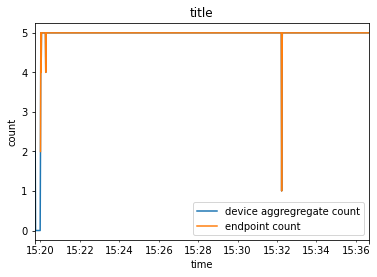

In [406]:
graphType1(devices, consumer, "test")

## Grafico 2

x = tempo

y = delay (device/draco, draco/kafka, device/kafka)

In [401]:
def graphType2(consumer, title):        

    delayDracoDevice = consumer.resample("1s", on='datetime').mean()["Delay Draco/Device"]
    delayKafkaDraco = consumer.resample("1s", on='datetime').mean()["Delay Kafka/Draco"]
    delayKafkaDevice = consumer.resample("1s", on='datetime').mean()["Delay Kafka/Device"]
    
    
    res = pd.DataFrame()
    res["Delay Draco/Device"] = delayDracoDevice
    res["Delay Kafka/Draco"] = delayKafkaDraco
    res["Delay Kafka/Device"] = delayKafkaDevice

    
    
    ax = res.plot()
    ax.set_xlabel("time")
    ax.set_ylabel("delay (ms)")
    ax.set_title(title)
    ax.plot()

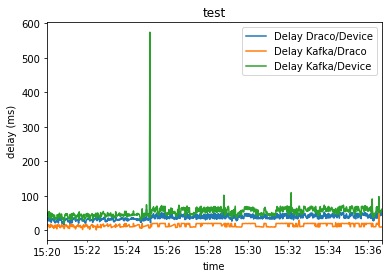

In [403]:
graphType2(consumer, "test")

# Grafico 3

riguarda un intero setting, non i singoli esperimenti come quelli di prima

In [43]:
def graphType3(experiment_set, variable_index, xlabel, title):
    metrics = {}
    experiments = os.listdir(experiment_subset)
    for experiment in experiments:
        consumer = readConsumer(experiment_set, experiment)
        devices = readAggregateDevices(experiment_set, experiment)
        label = experiment.split("_")[variable_index]
        metrics[label] = (consumer.shape[0] / devices.shape[0]) * 100
       
    result = pd.DataFrame.from_dict(metrics, orient="index")
    result.sort_index(axis=1, inplace=True)

    
    plt = result.plot(kind="bar", legend=False)
    plt.set_title(title)
    plt.set_xlabel(xlabel)
    plt.set_ylabel("#received / #sent")
    plt.plot()
    
    return result

In [66]:
experiment_set

'freqV3'

/home/monte97/.local/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3441: DtypeWarning: Columns (1,4) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/monte97/.local/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3441: DtypeWarning: Columns (1,4) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/monte97/.local/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3441: DtypeWarning: Columns (1,4) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


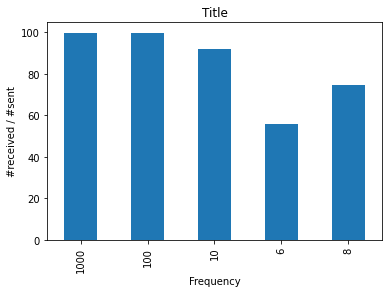

In [63]:
test = graphType3(experiment_set, 1, "Frequency", "Title")

In [65]:
test.index = test.index.astype(int)
test = test.sort_index(ascending=False)
test

,0
1000,99.460539
100,99.797800
10,91.857202
8,74.356317
6,55.699468


In [62]:
test

Int64Index([10, 100, 1000, 6, 8], dtype='int64')

# Grafico 4

X = variable che cambia nel setting
Y = ritardo medio end to end

In [26]:
def graphType4(experiment_set, variable_index, xlabel, title):
    metrics = {}
    experiments = os.listdir(experiment_subset)
    for experiment in experiments:
        label = experiment.split("_")[variable_index]
        consumer = readConsumer(experiment_set, experiment)
        metrics[label] = consumer["Delay Kafka/Device"].mean()

        
    
    result = pd.DataFrame.from_dict(metrics, orient="index")
    
    plt = result.plot(kind="bar", legend=False)
    plt.set_title(title)
    plt.set_xlabel(xlabel)
    plt.set_ylabel("delay(ms)")
    plt.plot()

In [27]:
graphType4(experiment_set, 1, "Frequency", "Title")

NameError: name 'readConsumer' is not defined

---

In [71]:
def test(x):
    print(x(10))

In [72]:
test(lambda x: x*2)

20
